# eMaize玉米育种挑战赛

在[quiz_emaize_tutorial_shared](https://cloud.tsinghua.edu.cn/f/3f4fc999720d45f198ca/)下载相关文件。

## eMaize背景简介
eMaize挑战赛是[一个通过机器学习方法预测玉米性状的比赛](http://emaize.imaze.org/emaize/emaize_cn.php)，要求我们以SNP作为特征，通过训练一个模型，**对玉米的三个性状进行预测**。

本教程将会包括：
- 介绍数据的情况，使用方式。
- 具体任务要求。
- 一些机器学习的概念方法以及工具使用的补充知识。

## 编程工具介绍


大作业需要使用python完成，推荐读者使用python3。我们需要一些python的工具包来实现部分功能。推荐使用包管理软件Anaconda来预装一些必需的包以及安装其他需要的包。另外强烈建议使用jupyter notebook进行代码编辑、运行和调试。具体使用方法请参考教程[Anaconda 和 jupyter](/appendix/appendix4.python-tutorial.md)相关指南。
如果本地缺少下列可能需要的包，请使用`pip`或者`conda`进行安装。如:

```
pip install tqdm
conda install sklearn
```

In [4]:
#导入必需的库
%pylab inline
import numpy as np
from sklearn.random_projection import SparseRandomProjection
import scipy.stats
import pandas as pd
import sklearn
import h5py
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from tqdm import tqdm_notebook as tqdm
from IPython.display import display, Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[1])
sns.set_style(styles[2])

## 数据介绍
原始数据中有6210个样本，其中4754个样本作为训练集，1456个样本作为测试集 <br>
- **genotype**：SNP (Single-nucleotide polymorphism) 数据
    每个位点可能有三种情况，如AA，AT，TT，每个样本SNP位点约为190万个，数据位置`data/genotype_2bit/`，包含十个染色体各自的SNP，使用时需要整合在一起。 <br>
- **trait**：
    共三种，trait1开花期，trait2株高，trait3产量，为连续值，只提供训练集样本的性状数据。`data/pheno_emaize.txt` <br>
 <br>
作为示例仅仅使用每个样本的5000个SNP，在做大作业的过程中请使用全部的SNP。<br>

### Genotype数据

#### SNP数据存储格式
txt存储格式不适合大数据读取的问题，对内存的占用过多 <br>
对于结构化的、能够存储为矩阵的数据，可以使用HDF5格式存取，内存占用小，读取速度快。
> tips: 在命令行查看数据shape的方法为：
cd至文件路径下，输入：h5ls filename

In [6]:
#使用h5py读取5000个SNP，此时数据为原始的碱基信息
with h5py.File('data/snp_5000','r') as f:
    print (list(f.keys()))
    snps = f['snp'][:]
snps.shape

['snp']


(5001, 6214)

In [7]:
snps

array([[b'snp', b'alleles', b'chrom', ..., b'L6208', b'L6209', b'L6210'],
       [b'chr1.s_164125122', b'C/A', b'1', ..., b'CC', b'CA', b'CC'],
       [b'chr1.s_274182854', b'T/A', b'1', ..., b'TT', b'TT', b'TT'],
       ...,
       [b'chr1.s_45679299', b'A/G', b'1', ..., b'AA', b'AA', b'AA'],
       [b'chr1.s_130850989', b'A/G', b'1', ..., b'AA', b'AA', b'AA'],
       [b'chr1.s_70612772', b'G/A', b'1', ..., b'GG', b'GG', b'GG']],
      dtype='|S16')

In [8]:
#使用h5py读取5000个SNP，此时为原始的碱基信息转化为数值信息后的数据
with h5py.File('data/2bit_geno','r') as f:
    print (list(f.keys()))
    snps_2bit = f['data'][:]
snps_2bit.shape

['data']


(10000, 6210)

In [53]:
snps_2bit

array([[1, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 1, 1]])

In [20]:
#使用h5py读取一个染色体的SNP示例，此时文件内为我们处理好的数值化数据，注意需要先解压文件：
with h5py.File('data/genotype_2bit/chr1.h5','r') as f:
    print (list(f.keys()))
    chr1_snps = f['data'][:]
chr1_snps.shape, chr1_snps.dtype

['data']


((575304, 6210), dtype('uint8'))

#### 性状数据
使用numpy/pandas均可读取性状数据，计算时一般使用numpy.array的形式

前4764个样本的性状是已知的，后1454个样本性状待预测

In [9]:
traits = pd.read_csv('data/pheno_emaize.txt','\t')
display(traits.head())
display(traits.tail())

,type,id,pedigree,trait1,trait2,trait3
0,training,L0001,f1_X_m1,-1.746103,-0.785525,-0.331637
1,training,L0002,f2_X_m1,-1.679248,-1.569490,-2.572614
2,training,L0003,f3_X_m1,-2.748920,-0.608644,-1.108812
3,training,L0004,f4_X_m1,-2.414647,-0.672045,-1.315051
4,training,L0005,f5_X_m1,-1.879812,-0.740913,-1.879181


,type,id,pedigree,trait1,trait2,trait3
6205,test,L6206,f203_X_m25,NaN,NaN,NaN
6206,test,L6207,f204_X_m25,NaN,NaN,NaN
6207,test,L6208,f205_X_m25,NaN,NaN,NaN
6208,test,L6209,f206_X_m25,NaN,NaN,NaN
6209,test,L6210,f207_X_m25,NaN,NaN,NaN


##### 查看性状的分布情况
注意，对性状数据已经做过了normalization

Text(0.5,1,'Normalized Trait3: Yield')

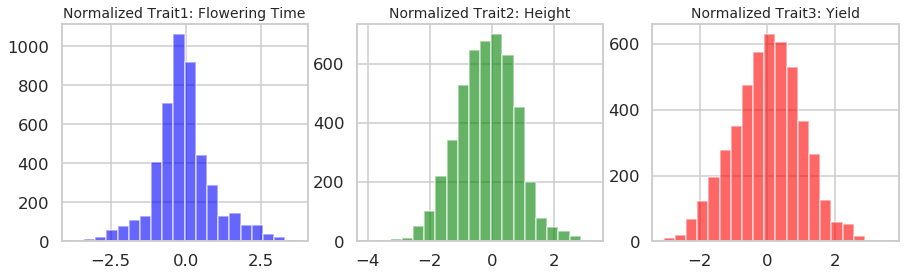

In [29]:
trait1 = np.array(traits['trait1'])[:4754]
trait2 = np.array(traits['trait2'])[:4754]
trait3 = np.array(traits['trait3'])[:4754]
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].hist(trait1,bins = 20,color='b',alpha=0.6)
ax[0].set_title('Normalized Trait1: Flowering Time',fontsize=14)
ax[1].hist(trait2,bins = 20,color='g',alpha=0.6)
ax[1].set_title('Normalized Trait2: Height',fontsize=14)               
ax[2].hist(trait3,bins = 20,color='r',alpha=0.6)
ax[2].set_title('Normalized Trait3: Yield',fontsize=14)

## Quiz具体要求
之前的部分我们介绍了基本的背景知识，接下来我们会提出解答本题目的具体要求：

- 完成**特征选择和特征筛除工作**。
- 完成**对三种性状的预测**并提交预测结果，允许多次提交预测结果以获得更好的结果。
- 提交一份**工作报告**，中英文不限，同时提交**源代码**。
- 选择性完成加分项内容。


### 进行特征选择和冗余特征筛除

本挑战原始特征数量接近2,000,000，超过大多数机器学习模型的输入限制，特征间相关性很强，冗余特征很多，且过多的特征数量导致计算开销非常大，这都需要完成特征选择和去除冗余的步骤。

鉴于本问题原始特征数量过于巨大，并不是每种特征选择和降维方法都适合，请读者思考和选择合适的特征选择与降维方法，在这里仅提供几个方法参考：
- 特征选择：
    - ANOVA（方差分析）
    - 基于模型权重排序（如线性模型）
- 降维：
    - PCA
    - SVD
    - Random Projection

> tips: 请思考是否需要针对特征选择或者降维后的数据做scale
    
    


### 完成对测试集三种性状的预测，尝试得到尽可能好的预测结果
- 请思考和探索使用何种回归模型，读者可以尝试多种模型并比较其结果，在*编程工具介绍*部分读者可以看到一些机器学习模型的方法，也推荐读者思考和使用其他模型。
- 思考和探索是否对每个性状使用不同的模型
- 根据训练集与测试集的特殊划分方式（见*查看训练集与测试集的划分*部分）思考可以使用的策略。

### 加分内容
为了更完整地展示emaize挑战的困难与有趣之处，我们为有余力的读者设置了更多的挑战。

#### 对模型进行鲁棒性测试 (10')
这是一个并不非常困难的但是对于本问题比较重要的工作，该工作可以细分为以下几项内容：
- 在读者已有的数据（训练集数据）上进行多轮（如100、1000轮）交叉验证，测试模型的鲁棒性
- 设计不同的数据集划分方式，除了随机划分训练集与验证集，还可以有其他特殊的设计方法
- 统计测试结果，以多种形式展现，包括统计数据和图示。

为了帮助读者完成测试，我们会给读者提供部分代码和一些相关的统计图，供读者使用和仿照设计，详见*补充知识*的*模型鲁棒性测试*部分。

#### 使用ANOVA进行特征选择的加速算法 (10')
方差分析方法可以利用p值挑选feature <br>
调用scipy.stats.f_oneway,利用SNPs和性状可以很容易地计算出p-value，进而挑选特征，但是对于大量数据来说速度较慢 <br>
我们可以设计一种加速ANOVA计算的方法完成计算，相比于scipy.stats的方法可以提升计算速度数百倍。为了帮助读者实现这一功能，我们提供给读者设计的基本思路，请参考*ANOVA加速算法部分*，有能力的读者可以根据基本思路实现ANOVA的加速算法。

#### 混合线性模型 (20')
育种领域的一个经典模型是混合线性模型(linear mixed model)，请尝试设计一个混合线性模型来解决本问题。

- 可以研究并调用[FaST-LMM package](https://github.com/MicrosoftGenomics/FaST-LMM)，研究其原理并应用于我们的数据中，试图在测试集上获得好的预测结果(5')

- 根据其思路进行改进，设计一个类似的混合线性模型，并且可以通过快速的交叉验证挑选超参数，最终在测试集上获得好的效果。详细内容可以参考[这篇文档](https://github.com/lulab/teaching_book/blob/master/quiz/quiz_emaize/assets/Mixed_ridge&Fast_cv.pdf)。(15')

## 补充知识（选读）

### 测试预测结果

##### 查看训练集与测试集的划分

请读者特别关注这个信息，训练集与测试集特殊的划分方式是本问题的一个特点与难点，也是想解决好本问题的关键。

下图中彩色部分为训练集性状，白色部分为待预测性状 <br>
可以发现其划分方式并不随机，这会导致常规的机器学习方法出现一些问题，常规的机器学习问题中，每个样本彼此独立，但是对于育种问题，很多样本可能有同一个父本或者母本，比如图中的每一行样本都来自同一个父本，每一列样本都来自同一个母本。读者需要自己思考待预测样本和已有样本的关系，结合机器学习的特点“通过学习已有数据的特征对未知数据进行预测”，思考并观察预测结果的好坏。

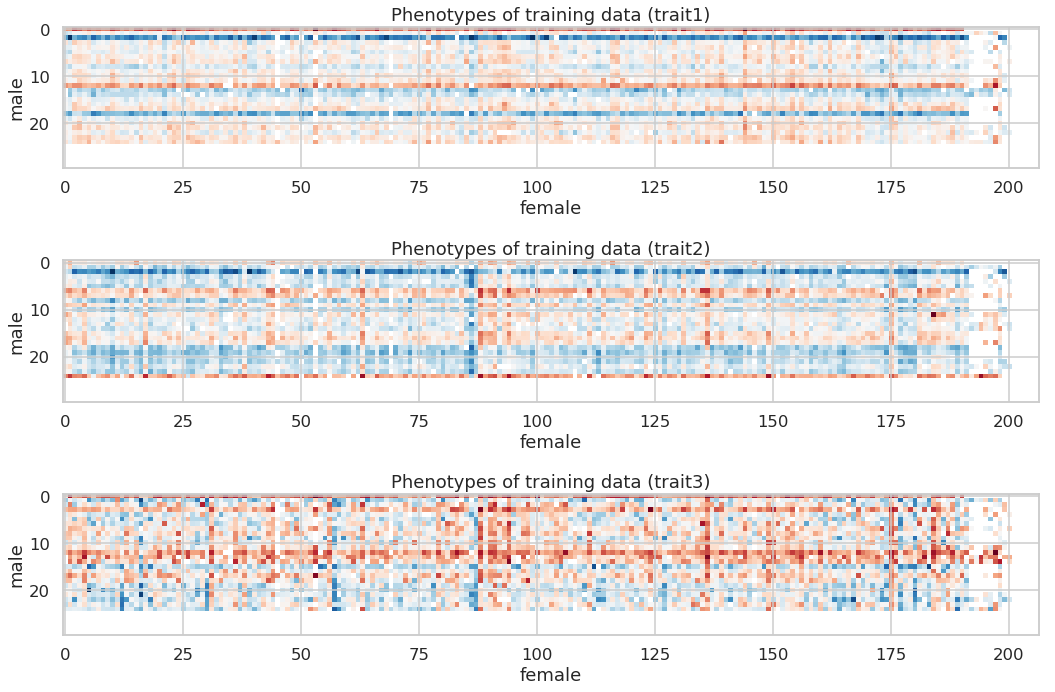

In [11]:
def generate_parent_table(phenotype_file):
    phenotypes = pd.read_table(phenotype_file)
    pedigree = phenotypes['pedigree'].str.split('_', expand=True)
    pedigree.columns = ['f', 'X', 'm']
    phenotypes = pd.concat([phenotypes, pedigree], axis=1)
    phenotypes['number'] = np.arange(phenotypes.shape[0])
    parent_table = phenotypes.pivot_table(values='number'
                                          , index=['m'], columns=['f'], dropna=False)
    male_ids = ['m%d' % i for i in range(1, parent_table.shape[0] + 1)]
    female_ids = ['f%d' % i for i in range(1, parent_table.shape[1] + 1)]
    parent_table = parent_table.loc[male_ids, female_ids]
    return parent_table
phenotype_file = 'data/pheno_emaize.txt'
parent_table = generate_parent_table(phenotype_file)
phenotypes = pd.read_table('data/pheno_emaize.txt')
fig, ax = subplots(3,1, figsize=(15, 10))
for i in range(3):
    trait = ['trait1','trait2','trait3'][i]
    ax[i].imshow(np.take(np.ravel(phenotypes[trait].values), parent_table), cmap=cm.RdBu)
    ax[i].set_title('Phenotypes of training data (%s)'%trait)
    ax[i].set_ylabel('male')
    ax[i].set_xlabel('female')
plt.tight_layout()

##### 测试集具体划分

我们会把测试区域分为三个部分，来测试提交的结果，三个区域分别为下图的淡蓝色，黄色和红色区域，请读者思考它们各自的特征。

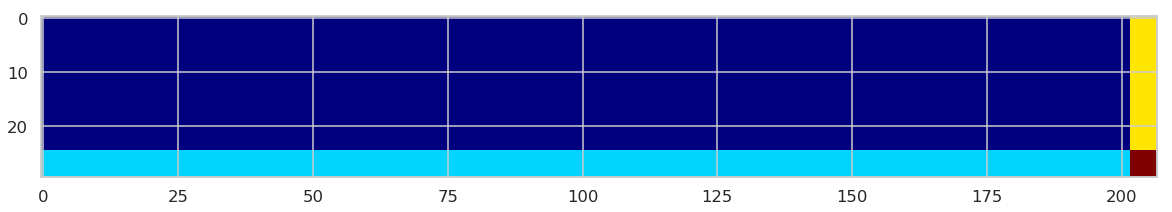

In [45]:
fig,ax=plt.subplots(figsize=(20,5))
testexample = np.zeros([30,207])
testexample[25:,:202] = 100
testexample[:25,202:] = 200
testexample[25:,202:] = 300
ax.imshow(testexample,cmap='jet')

##### 评价指标
对于回归问题，我们一般使用$r^2$和pearson correlation coefficient(PCC)衡量，其定义如下：

$r^2 = 1-\frac{SS_{res}}{SS_{tot}}$<br>
$pcc = \frac{cov(X,Y)}{\sigma_X \sigma_Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y} $<br>

###  将SNP数据编码为向量
每个位点的碱基只有三种情况，不会出现更多碱基组合的可能，比如某位点仅有AA，AT，TT三种可能的情况<br>
我们可以采取三种方式对其编码：
- 转化为0、1、2。找到minor allele frequency（MAF），即两种碱基（如A、T）中出现频率低的那个，以A作为MAF为例，则TT为0，AT为1，AA为2，这样可以突出MAF
- 转化为3-bit one hot vector,$[1,0,0]^T,[0,1,0]^T,[0,0,1]^T$这样可以保持三种向量在空间距离的一致
- 转化为2-bit vector,则AA，AT，TT分别编为$[1,0]^T,[1,1]^T,[0,1]^T$,不需要考虑MAF
我们采取第三种方式处理了数据并提供给读者

#### 具体处理过程

In [46]:
def convert_2bit(seq):
    genotypes = np.zeros([6210,2])
    a = seq[1].split('/')
    for i in range(6210):
        if seq[4:][i] == a[0] + a[0]:
            genotypes[i] = np.array([0,1])
        if seq[4:][i] == a[0] + a[1]:
            genotypes[i] = np.array([1,0])
        if seq[4:][i] == a[1] + a[1]:
            genotypes[i] = np.array([1,1])
    genotypes = genotypes.astype('int').T
    return genotypes

真实转换时python的转换速度较慢，这里为了展示基本的原理使用了python来演示。

In [64]:
snps = snps.astype('str')
snps.shape

In [63]:
convert_2bit(snps[2].astype('str'))

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
geno_conv = np.ndarray([10000,6210])
for i in tqdm(range(5000)):
    geno_conv[i*2:(i+1)*2] = convert_2bit(snps[i+1])

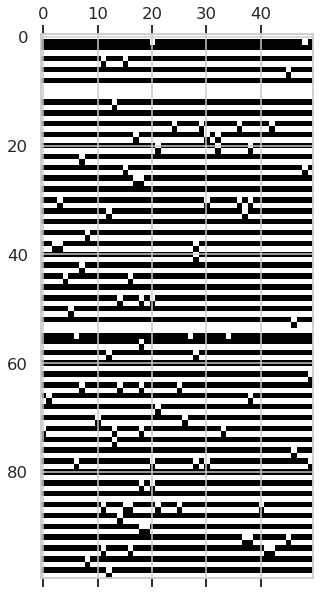

In [71]:
#查看SNP的大致情况，取前100行（50个位点），前50个样本，
fig, ax = plt.subplots(figsize=(20,10))
ax.matshow(geno_conv[:100,:50],cmap = cm.binary_r)

### 模型鲁棒性测试

#### 设计特殊的交叉验证方式
不同的样本具有关联性，有的样本可能来自同一亲本，而训练集和测试集的划分并不是随机的
因此我们可以专门设计交叉验证时数据集的划分方式：
- random
- by female
- by male
- cross sampling

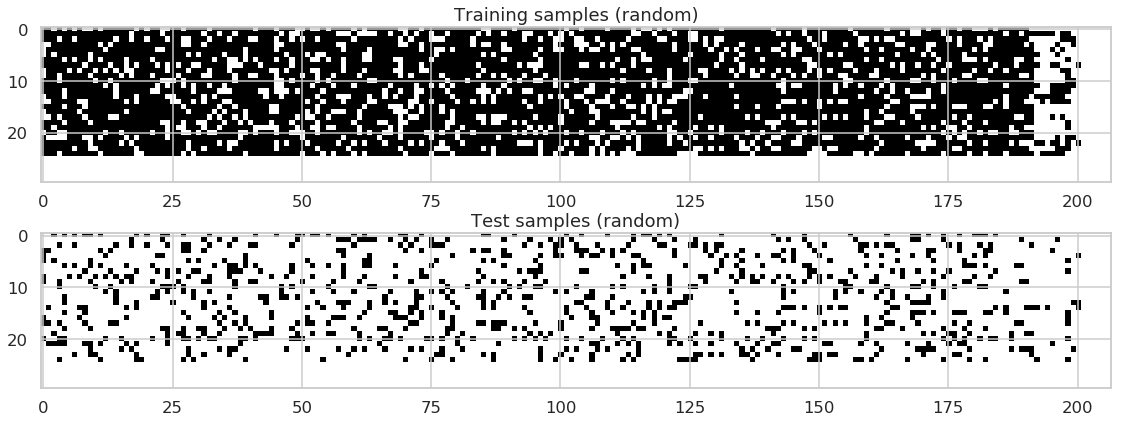

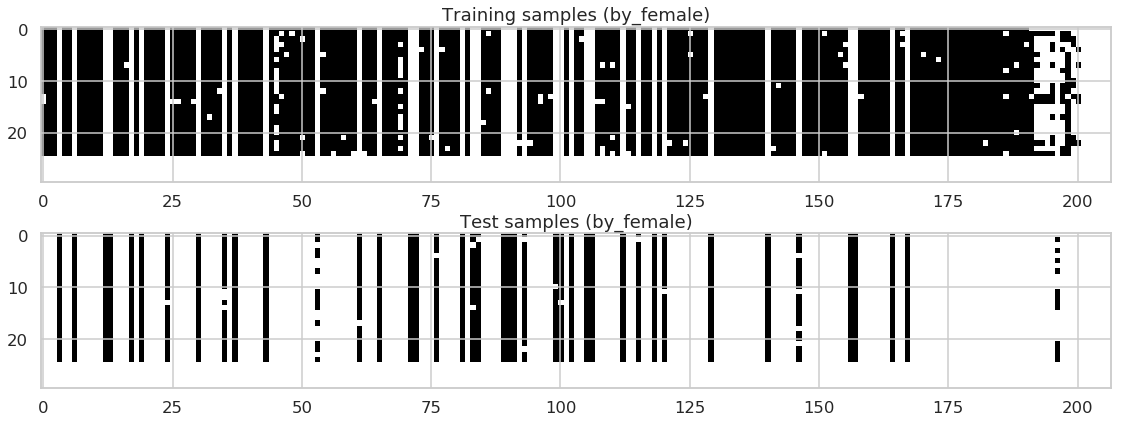

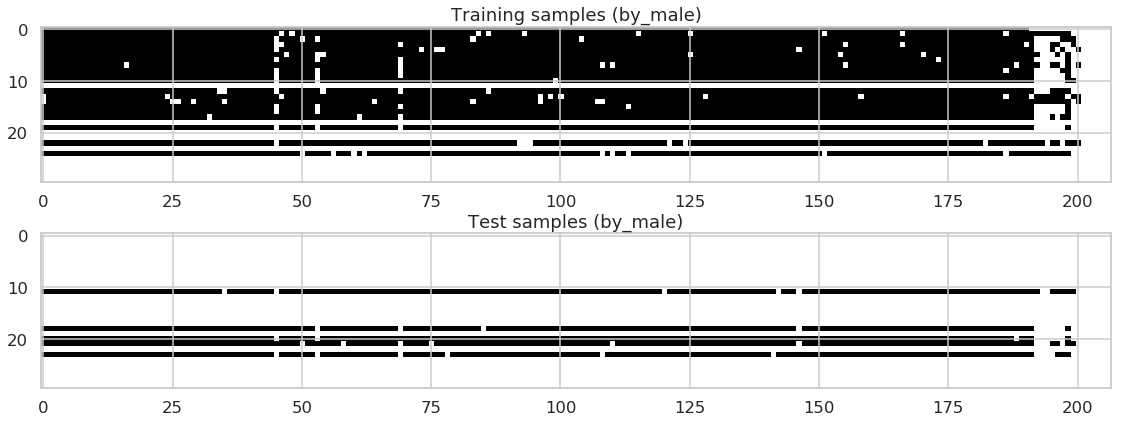

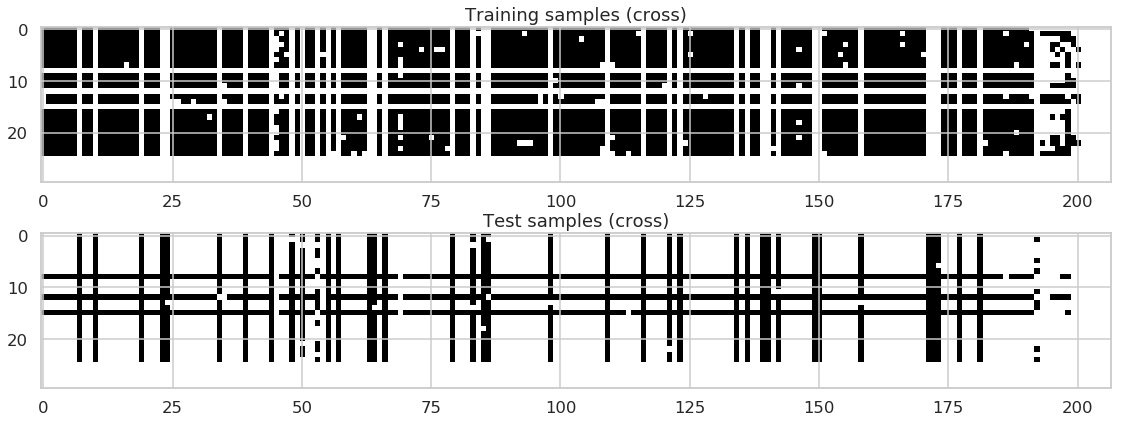

In [73]:
for method in ('random', 'by_female', 'by_male', 'cross'):
    with h5py.File('data/cv_index.%s'%method, 'r') as f:
        index_train = f['0/train'][:]
        index_test = f['0/test'][:]
    fig, ax = subplots(2, 1, figsize=(16, 6))
    sampling_table = np.zeros(np.prod(parent_table.shape))
    sampling_table[index_train] = 1
    sampling_table = np.take(sampling_table, parent_table)
    ax[0].imshow(sampling_table, cmap=cm.Greys)
    ax[0].set_title('Training samples (%s)'%method)

    sampling_table = np.zeros(np.prod(parent_table.shape))
    sampling_table[index_test] = 1
    sampling_table = np.take(sampling_table, parent_table)
    ax[1].imshow(sampling_table, cmap=cm.Greys)
    ax[1].set_title('Test samples (%s)'%method)
    plt.tight_layout()

![plots](plots/0.png)
![plots](plots/1.png)
![plots](plots/2.png)
![plots](plots/3.png)
![plots](plots/4.png)
![plots](plots/5.png)
![plots](plots/6.png)

### ANOVA加速算法
思路简要提示：

- Step 1. Calculate $y,{y}^2,N,{SS}_{tot}$

$$
y = y - \bar y\\
{y}^2 = y * y\\
{SS}_{tot} = \sum({y}^2)
$$
    And N is the first dimension of X

- Step 2. We calculate ${SS}_{bn}$by the following operations:

    - We first define a mask which indicate three different genotypes:$[0,1],[1,0],[1,1]$ using logical operations.

    - Then we calculate every features' (genotypes' rows') sum and define it as ${N}_i$, we use logic calculation to define A which is the positive position of ${N}_i$ 

    - Use masks to pick up three kinds of y  and calculate the sum each.

    - for three conditions calculate the sum of y and mask's mutiplication as S.

    - At last we calculate ${SS}_{bn}$ = ${S}^2$ and we construct the ${SS}_{bn}$ matrix by indices A. At the True position we fill in the value of ${SS}_{bn}$, at the False position we fill in zero.

- Step 3. We calculate F at this step
first we calculate ${SS}_{wn}$ = ${SS}_{tot}$ - ${SS}_{bn}$

M is the sum of A by rows, then we have:

$$
F = \frac{{MS}_{between}}{{MS}_{within}} = \frac{{SS}_{between}/(M-1)}{{SS}_{within}/(N-M)}
$$

- Step 4. Use scipy.stats module and F to calculate p-value         